In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('..', 'input')

# read prepare further data
* fill in lesions, imagepath,celltype and cancer type
* read mnist28 file since this one has prepared a compressed format of all images, lets have a look if this files does the job
* check if the minst file label is the same as the tile cell type idx
* encode the tile_df such that the basic fields become all numeric

In [14]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'melanoma ',   #this is an error in the other scripts
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [15]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0005263,ISIC_0026999,nv,histo,male,back,../input/ham10000_images_part_1/ISIC_0026981.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [16]:
images=pd.read_csv('../input/hmnist_28_28_RGB.csv')

In [17]:
#check  image label equals tiledf celltype
(images.label==tile_df.cell_type_idx).mean()

1.0

In [18]:
from sklearn.preprocessing import LabelEncoder
Encoder_X = LabelEncoder() 
for col in tile_df.columns:
    if tile_df.dtypes[col]=='object':
        tile_df[col]=col+'_'+tile_df[col].map(str)
        tile_df[col] = Encoder_X.fit_transform(tile_df[col])
Encoder_y=LabelEncoder()
#tile_df

In [19]:
tile_df[['dx','dx_type','age','sex','localization','cell_type']].head()

,dx,dx_type,age,sex,localization,cell_type
0,2,3,80.0,1,11,2
1,2,3,80.0,1,11,2
2,2,3,80.0,1,11,2
3,2,3,80.0,1,11,2
4,2,3,75.0,1,4,2


# define three functions
* list of classifiers
* tree function
* classification function

In [20]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC,SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier,Perceptron,LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor,BernoulliRBM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.svm import LinearSVR,SVC
from sklearn.utils import check_array


class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed
    
Classifiers = [
               #Perceptron(n_jobs=-1),
               #SVR(kernel='rbf',C=1.0, epsilon=0.2),
               #CalibratedClassifierCV(LinearDiscriminantAnalysis(), cv=4, method='sigmoid'),    
               #OneVsRestClassifier( SVC(    C=50,kernel='rbf',gamma=1.4, coef0=1,cache_size=3000,)),
               KNeighborsClassifier(10),
               DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=200),
               ExtraTreesClassifier(n_estimators=250,random_state=0), 
               OneVsRestClassifier(ExtraTreesClassifier(n_estimators=10)) , 
               #MLPClassifier(alpha=0.510,activation='logistic'),
               LinearDiscriminantAnalysis(),
               #OneVsRestClassifier(GaussianNB()),
               AdaBoostClassifier(),
               #GaussianNB(),
               #QuadraticDiscriminantAnalysis(),
               SGDClassifier(average=True,max_iter=100),
               XGBClassifier(max_depth=5, base_score=0.005),
               LogisticRegression(C=1.0,multi_class='multinomial',penalty='l2', solver='saga',n_jobs=-1),
               LabelPropagation(n_jobs=-1),
               #LinearSVC(),
               #MultinomialNB(alpha=.01),    
                   make_pipeline(
                    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
                    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
                    AdaBoostClassifier()
                ),

              ]

In [21]:
def treeprint(estimator):
    # Using those arrays, we can parse the tree structure:

    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
    print()
    return

In [22]:
def klasseer(e_,mtrain,mtest,veld,idvld,thres,probtrigger):
    # e_ total matrix without veld, 
    # veld the training field
    #thres  threshold to select features
    label = mtrain[veld]
    # select features find most relevant ifo threshold
    #e_=e_[1:]
    clf = ExtraTreesClassifier(n_estimators=100)
    ncomp=int(e_.shape[1]-3)
    model = SelectFromModel(clf, prefit=True,threshold =(thres)/1000)
       # SVD
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=ncomp, n_iter=7, random_state=42)
    #svd transformation is trying to throw away the noise
    #e_=svd.fit_transform(e_)


       #tsne not used
    from sklearn.manifold import TSNE
    e_=TSNE(n_components=3).fit_transform(e_)
    #from sklearn.metrics.pairwise import cosine_similarity
    
    #robustSVD not used
    #A_,e1_,e_,s_=robustSVD(e_,140)
    clf = clf.fit( e_[:len(mtrain)], label)
    New_features = model.transform( e_[:len(mtrain)])
    Test_features= model.transform(e_[-len(mtest):])
    #New_features =  e_[:len(mtrain)]
    #Test_features= e_[-len(mtest):] 
    pd.DataFrame(New_features).plot.scatter(x=0,y=1,c=mtrain[veld]+1)
    pd.DataFrame(np.concatenate((New_features,Test_features))).plot.scatter(x=0,y=1,c=['r' for x in range(len(mtrain))]+['g' for x in range(len(mtest))])    

    print('Model with threshold',thres/1000,New_features.shape,Test_features.shape,e_.shape)
    print('____________________________________________________')
    
    Model = []
    Accuracy = []
    for clf in Classifiers:
        #train
        fit=clf.fit(New_features,label)
        #if clf.__class__.__name__=='DecisionTreeClassifier':
            #treeprint(clf)
        pred=fit.predict(New_features)
        Model.append(clf.__class__.__name__)
        Accuracy.append(accuracy_score(mtrain[veld],pred))
        #predict
        sub = pd.DataFrame({idvld: mtest[idvld],veld: fit.predict(Test_features)})
        sub.plot(x=idvld,kind='kde',title=clf.__class__.__name__ +str(( mtrain[veld]==pred).mean()) +'prcnt') 
        sub2=pd.DataFrame(pred,columns=[veld])
        #estimate sample if  accuracy
        if veld in mtest.columns:
            print( clf.__class__.__name__ +str(round( accuracy_score(mtrain[veld],pred),2)*100 )+'prcnt accuracy versus unknown',(sub[veld]==mtest[veld]).mean() )
        #write results
        klassnaam=clf.__class__.__name__+".csv"
        sub.to_csv(klassnaam, index=False)
        if probtrigger:
            pred_prob=fit.predict_proba(Test_features)
            sub=pd.DataFrame(pred_prob)
    return sub

In [23]:
images=images.reset_index()
images=(images.T.append(tile_df[['dx_type','age','sex','localization']].T)).T
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images.drop(['label'],axis=1),images['label'], test_size=0.2, random_state=42)

Model with threshold 1e-05 (8012, 3) (2003, 3) (10015, 3)
____________________________________________________
KNeighborsClassifier74.0prcnt accuracy versus unknown 0.6939590614078882
DecisionTreeClassifier100.0prcnt accuracy versus unknown 0.6135796305541688
RandomForestClassifier100.0prcnt accuracy versus unknown 0.6979530703944083
ExtraTreesClassifier100.0prcnt accuracy versus unknown 0.689965052421368
OneVsRestClassifier100.0prcnt accuracy versus unknown 0.6879680479281078
LinearDiscriminantAnalysis66.0prcnt accuracy versus unknown 0.6570144782825761
AdaBoostClassifier65.0prcnt accuracy versus unknown 0.6475287069395906


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier65.0prcnt accuracy versus unknown 0.6570144782825761
XGBClassifier74.0prcnt accuracy versus unknown 0.6864702945581628
LogisticRegression66.0prcnt accuracy versus unknown 0.6630054917623565


/opt/conda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: divide by zero encountered in true_divide
  probabilities /= normalizer
/opt/conda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LabelPropagation100.0prcnt accuracy versus unknown 0.6615077383924114
Pipeline67.0prcnt accuracy versus unknown 0.6585122316525213


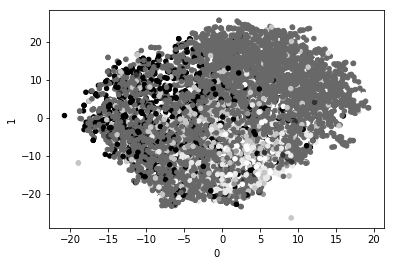

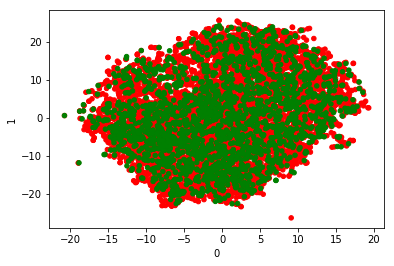

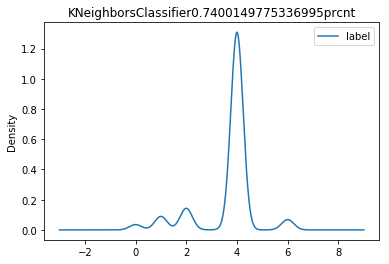

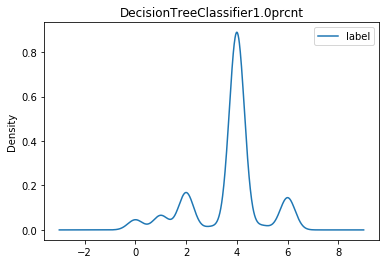

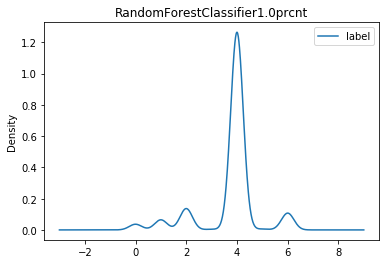

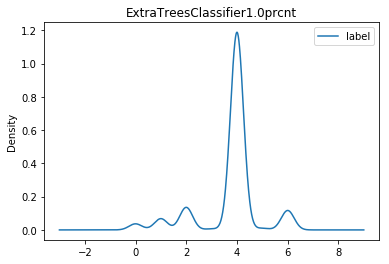

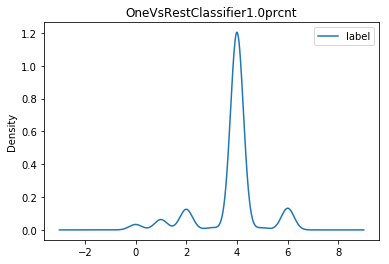

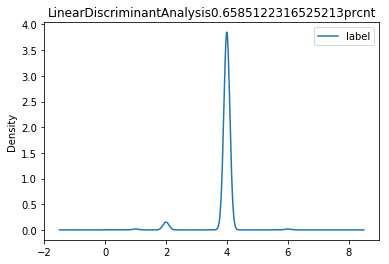

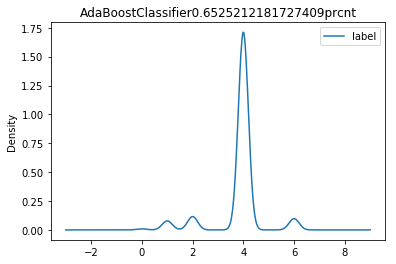

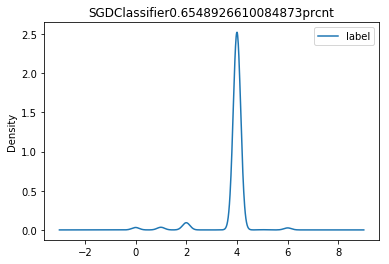

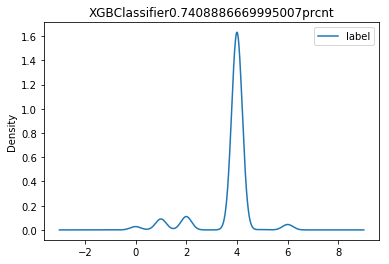

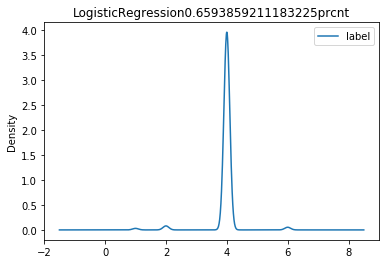

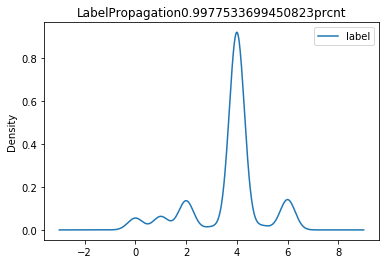

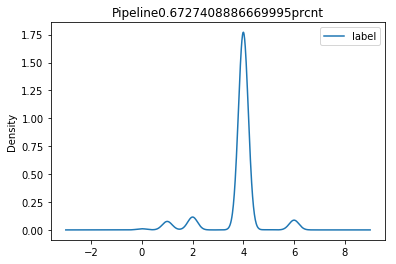

In [24]:
totaal=(X_train.append(X_test)).fillna(0)
totaal=totaal.drop('index',axis=1).values

subx=klasseer(totaal,(X_train.T.append(y_train.T)).T,(X_test.T.append(y_test.T)).T,'label','index',0.01,False)